**Key things to learn**

- XGBOOST 
    - https://sadanand-singh.github.io/posts/treebasedmodels/#bootstrap-aggregating-bagging
    - https://sadanand-singh.github.io/posts/boostedtrees/
    - https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d
    - https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283
    - http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/
    - https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
    - https://xgboost.readthedocs.io/en/latest/model.html
- lightgbm 
- feature plots 
- validation data strategy 

**Duplicate Detection**

**Competition Metric: AUC (Area Under the Curve)**

- [3rd place solution](http://blog.kaggle.com/2016/07/27/avito-duplicate-ads-detection-winners-interview-3rd-place-mario-gerard-kele-praveen-gilberto/)
- [2nd place solution](http://blog.kaggle.com/2016/08/31/avito-duplicate-ads-detection-winners-interview-2nd-place-team-the-quants-mikel-peter-marios-sonny/)
- [1st Place solution](http://blog.kaggle.com/2016/08/24/avito-duplicate-ads-detection-winners-interview-1st-place-team-devil-team-stanislav-dmitrii/)

## Data

In this competition, you will predict whether pairs of ads are duplicates. The data is captured in the following schema:
    
> ![img](./avito-dup.svg)


To ensure that winning models are robust enough to generalize to new duplicate cases, the train and test datasets are sampled from different time intervals. Hence, you may see different distributions of duplicates in train/test datasets. 

### File descriptions
- **ItemPairs_test.csv** – Pairs of ads that are duplicate and not duplicates on which to train.
    - itemID_1 – identifier of the first ad.
    - itemID_2 – identifier of the second ad.
    - isDuplicate – target field. If itemID_1 and itemID_2 are duplicates or not (0 = not duplicate, 1 = duplicate).
    - generationMethod – training data generation method. Different generation methods have different noise levels.
    - 1 = targets produced by humans when they consider only pair of ads.
    - 2 = targets produced by automatic algorithms.
    - 3 = targets produced by humans during analyses of all ads for the same owner.
- **ItemPairs_test.csv** – Pairs of ads to predict duplicate probability.
    - id – row identifier.
    - itemID_1 – identifier of the first ad. These ads are not present in train data.
    - itemID_2 – identifier of the second ad. These ads are not present in train data.
- **ItemInfo_train.csv** Information about each ad for training:
    - itemID – ad identifier (as in ItemPairs.tsv).
    - categoryID – identifier of ad category (as in Category.tsv).
    - title – ad title.
    - description – full text with the ad's description.
    - images_array – list of image identifiers associated with this ad. (Refer to Images.zip how to find each image by its id).
    - attrsJSON – additional parameters of the ad in JSON format.
    - price – ad price.
    - locationID – ad location identifier (as in Location.tsv).
    - metroID – identifier of a closest metro station to ad location.
    - lat – latitude of ad location.
    - lon – longitude of ad location.
- **ItemInfo_test.csv**. Information about each ad to predict duplicate probability. Structure is identical to ItemInfo_train.csv.
- Images_X.zip – 10 archives with images inside. There are 10 mln+ 208x156 .jpg image files. Placing all of them inside a single folder will be really painful for a file system and accessing each image will take a lot of time. Thats why all images are distributed between 100 folders. To find and image folder you need to take last 2 digits of image id and remove leading zero if any. Folders are grouped into archives by their first digit (0 if no digit). Example: you need to find image for image_id = 123456. Take last 2 digits = 56, thats why it is contained in 56 folder. This folder is contained in Images_5.zip archive.
- **Category.csv**
    - categoryID – identifier of the category.
    - parentCategoryID – identifier of parent category.
- **Location.csv**
    - locationID – identifier of the location.
    - regionID – identifier of region.
- **Random_submission.csv** – correct submission format (probabilities generated randomly)
    - id – the list of pairs from ItemPairs_test,
    - probability - probability of the pair being duplicates

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from imports import * 
from structured import *

Using TensorFlow backend.


In [3]:
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))

In [4]:
from path import Path

In [5]:
PATH = Path('./data/')

In [6]:
! ls ./data

Category.csv
Category.csv.zip
ItemInfo_test.csv
ItemInfo_test.csv.zip
ItemInfo_train.csv
ItemInfo_train.csv.zip
ItemPairs_test.csv
ItemPairs_test.csv.zip
ItemPairs_train.csv
ItemPairs_train.csv.zip
Location.csv
Location.csv.zip


In [7]:
train_pairs = pd.read_csv(PATH / 'ItemPairs_train.csv')

In [8]:
train_iteminfo = pd.read_csv(PATH/'ItemInfo_train.csv')

In [9]:
train_locations = pd.read_csv(PATH/'Location.csv')

In [10]:
category = pd.read_csv(PATH/'Category.csv')

### Understanding the data and the problem

In [11]:
train_pairs.head()

,itemID_1,itemID_2,isDuplicate,generationMethod
0,1,4112648,1,1
1,3,1991275,1,1
2,4,1223296,0,1
3,7,1058851,1,1
4,8,2161930,1,1


In [12]:
train_pairs.shape

(2991396, 4)

Lets see distribution of target variable. 
It is a binary variable with 0/1 as label.  

(array([1727117.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1264279.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

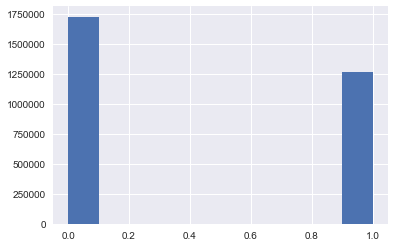

In [13]:
plt.hist(train_pairs['isDuplicate'].values)

> ```Inference```: there are ```175000K``` not duplicates and ```12500K``` duplicates in the dataset.

How does this distribution splits with ```generation method``` ? 

In [14]:
train_pairs['generationMethod'].unique()

array([1, 2, 3], dtype=int64)

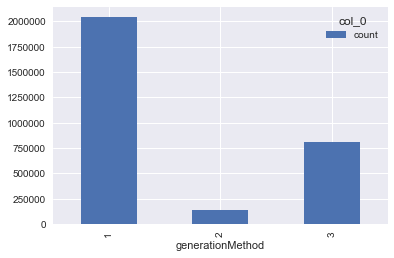

In [15]:
my_tab = pd.crosstab(index = train_pairs["generationMethod"],  columns="count")      # Name the count column
my_tab.plot.bar()

> Inference: automatically generated tags may have high noise

In [16]:
train_iteminfo.head().T

,0,1,2,3,4
itemID,1,3,4,7,8
categoryID,81,14,84,84,39
title,Продам Камаз 6520,Yamaha r6,iPhone 3gs 8gb,Xiaomi Mi4 3гб RAM + 16гб ROM белый,Лыжные ботинки
description,Продам Камаз 6520 20 тонн,Весь в тюнинге.,"Телефон в хорошем состоянии, трещин и сколов н...","Отличный подарок на новый год от ""китайской ap...","Лыжные ботинки в хорошем состоянии, 34 размер"
images_array,"1064094, 5252822, 6645873, 6960145, 9230265","11919573, 14412228, 3204180, 6646877","14384831, 6102021",NaN,"13718854, 4787310"
attrsJSON,"{""Вид техники"":""Грузовики""}","{""Вид техники"":""Мотоциклы"", ""Вид мотоцикла"":""С...","{""Вид телефона"":""iPhone""}","{""Вид телефона"":""Другие марки""}","{""Вид товара"":""Зимние виды спорта""}"
price,300000,300000,3500,13500,500
locationID,648140,639040,640650,662210,624360
metroID,NaN,NaN,NaN,NaN,NaN
lat,64.6869,55.678,56.2394,55.7772,55.7772


Null percentage in the dataset

In [17]:
train_iteminfo.isnull().sum() / len(train_iteminfo) *100

itemID           0.000000
categoryID       0.000000
title            0.000030
description      0.003139
images_array    11.900480
attrsJSON        3.109119
price            9.631189
locationID       0.000000
metroID         67.087523
lat              0.000000
lon              0.000000
dtype: float64

number of unique values in the info frame.

In [18]:
for c ,_ in train_iteminfo.items():
    print(c, ': ', train_iteminfo[c].nunique())

itemID :  3344613
categoryID :  51
title :  1748591
description :  2920254
images_array :  2796855
attrsJSON :  497393
price :  43080
locationID :  3347
metroID :  306
lat :  53117
lon :  53219


Let's merge everything in a single frame.

In [23]:
train_iteminfo.shape

(3344613, 11)

In [19]:
x = pd.merge(train_iteminfo, category, left_on = 'categoryID', right_on='categoryID', how='left')

In [20]:
x = pd.merge(x, train_locations, left_on = 'locationID', right_on='locationID', how='left')

In [21]:
x.head().T

,0,1,2,3,4
itemID,1,3,4,7,8
categoryID,81,14,84,84,39
title,Продам Камаз 6520,Yamaha r6,iPhone 3gs 8gb,Xiaomi Mi4 3гб RAM + 16гб ROM белый,Лыжные ботинки
description,Продам Камаз 6520 20 тонн,Весь в тюнинге.,"Телефон в хорошем состоянии, трещин и сколов н...","Отличный подарок на новый год от ""китайской ap...","Лыжные ботинки в хорошем состоянии, 34 размер"
images_array,"1064094, 5252822, 6645873, 6960145, 9230265","11919573, 14412228, 3204180, 6646877","14384831, 6102021",NaN,"13718854, 4787310"
attrsJSON,"{""Вид техники"":""Грузовики""}","{""Вид техники"":""Мотоциклы"", ""Вид мотоцикла"":""С...","{""Вид телефона"":""iPhone""}","{""Вид телефона"":""Другие марки""}","{""Вид товара"":""Зимние виды спорта""}"
price,300000,300000,3500,13500,500
locationID,648140,639040,640650,662210,624360
metroID,NaN,NaN,NaN,NaN,NaN
lat,64.6869,55.678,56.2394,55.7772,55.7772


In [22]:
x.shape

(3344613, 13)

In [25]:
train_pairs.head().T

,0,1,2,3,4
itemID_1,1,3,4,7,8
itemID_2,4112648,1991275,1223296,1058851,2161930
isDuplicate,1,1,0,1,1
generationMethod,1,1,1,1,1


verify that each itemID has meta data

In [34]:
i1 = set(train_pairs['itemID_1'])
i2 = set(train_pairs['itemID_2'])
items_pairs = i1.union(i2)
i = set(x['itemID'])
i == items_pairs

True

What problem are solving in this challenge ? 

- *Thought 1*: Collapse each ad to a vector and then compute some kind of similarity score

In [35]:
x['categoryID'].nunique()

51